In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn']

In [3]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA


In [4]:
# # load weights and set these weights to current additive gpmap to 
# # check whether x_to_phi is working correctly
# mpsa_theta = pd.read_csv('data/mpsa_ge_additive_theta.csv',index_col=[0])
# mpsa_theta

In [5]:
# # set positional argumnets for gpmap function
# L = len(data_df['x'][0])
# alphabet=['A','C','G','U']

In [6]:
# # instantiate gpmap object
# gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # set parameters to mpsa model 
# # this is done to check for validity of updated x_to_phi
# gpmap.set_params(theta_0=-2.508132402430794,
#                  theta_lc=mpsa_theta.values)

# # get test set data.
# x_test = test_df['x'].values
# y_test = test_df['y'].values

### Updated phi usage
Computed directly from gpmap object

In [7]:
# phi = gpmap.x_to_phi(x_test)

### Validate gpmap object usage

In [8]:
# fig, ax = plt.subplots(figsize=(4.5,4.5))
# ax.scatter(phi,y_test,s=3,alpha=0.2,c='b')
# ax.set_ylabel('y (test)')
# ax.set_xlabel('phi')

## Create new gpmap to test out with multi-target GE regression

In [9]:
L = len(data_df['x'][0])
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet=['A','C','G','T'])

2022-03-22 16:33:19.447690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [10]:
mp_GE_1 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=12)
mp_GE_2 = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=10)

mp_mpa = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=10,
                                                                      K=50,
                                                                      eta=1e-5,)


about to call super from discrete Agnostic


In [11]:
mp_mpa.Y

10

In [12]:
# number_x_nodes = 36
# number_of_targets = 3
# mp_shapes = [1,1,10]

# start_pointer = number_x_nodes
# end_pointer = None
# for output_layer_index in range(len(mp_shapes)):
    
#     end_pointer = start_pointer+mp_shapes[output_layer_index]
#     print(output_layer_index,start_pointer, end_pointer)
    
#     start_pointer = end_pointer

0 36 37
1 37 38
2 38 48


In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_GE_1,mp_GE_2,mp_mpa])

In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 48)]        0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 36)           0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           37          ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# to check if weights update before and after training
#mp_GE_1_GE_weights = mp_GE_1.yhat._trainable_weights[1].numpy().copy()

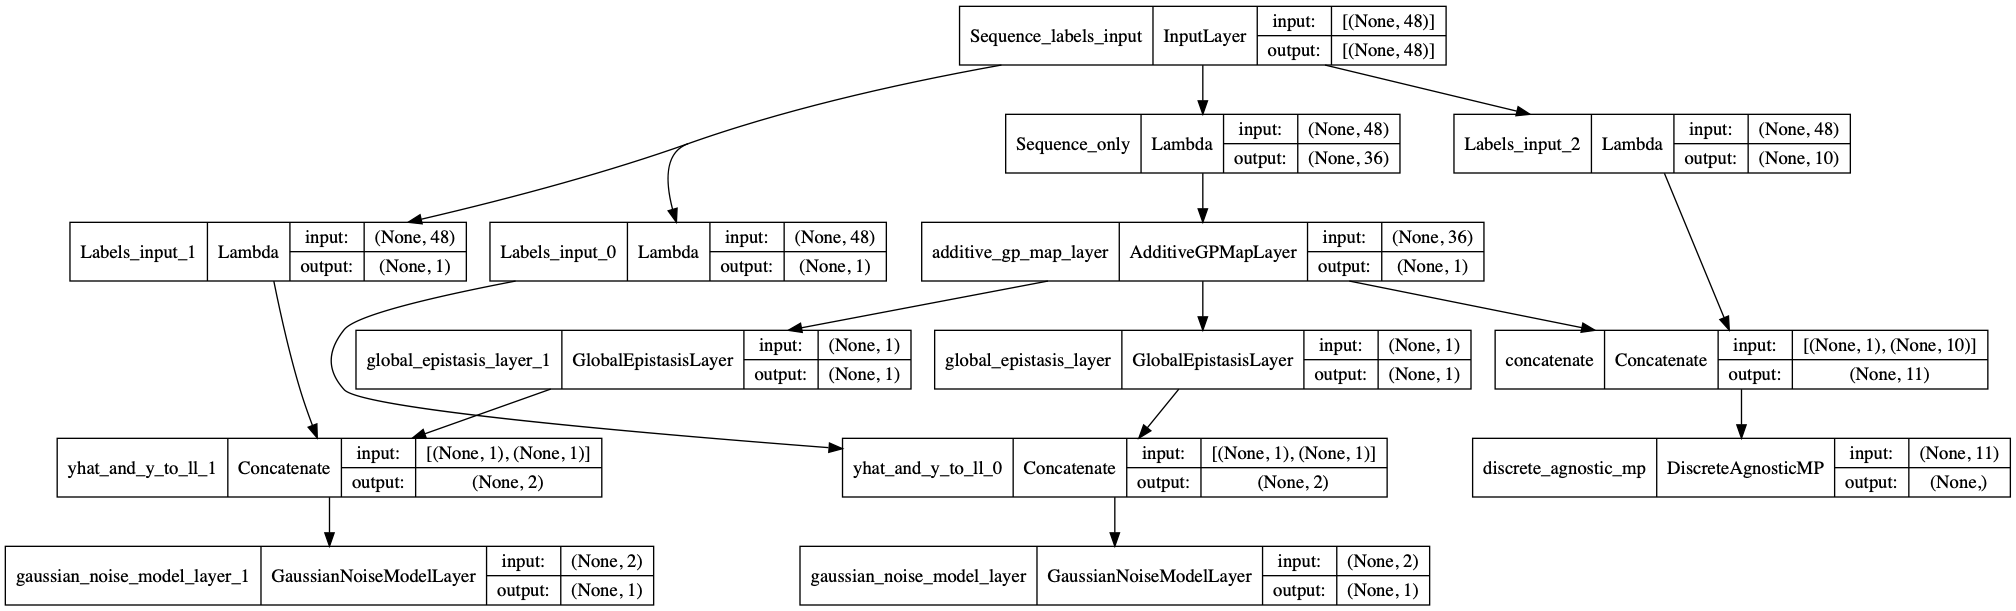

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False)

Each measurement can call it's specific $\phi$ to $y$ functions:

## Prepare data with two targets 
In this case two replicate PSI measurements for BRCA2

In [18]:
MPSA_data_lib1_rep1 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep1.csv')
MPSA_data_lib1_rep2 = pd.read_csv('data/20.08.16_mpsa_data/brca2_lib1_rep2.csv')

In [19]:
#BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep3,on='ss',how='outer')
BRCA_df = MPSA_data_lib1_rep1.merge(MPSA_data_lib1_rep2,on='ss',how='outer').copy()
BRCA_df = BRCA_df[['ss', 'log_psi_x', 'log_psi_y']].copy()
BRCA_df.columns = ['x','y1','y2']

# drop nans for now, though in future this should be allowed. 
BRCA_df.dropna(inplace=True)

# split into train-val-test sets. 
np.random.seed(777)
BRCA_df['set'] = np.random.choice(a=['training', 'validation', 'test'], 
                                   p=[.8,.1,.1], 
                                   size=len(BRCA_df))
BRCA_df

,x,y1,y2,set
0,AAAGCAAAA,-3.751854,-3.115981,training
1,AAAGCAAAC,-2.697741,-2.991176,training
2,AAAGCAAAG,-2.242947,-2.666159,training
3,AAAGCAAAT,-3.067251,-2.823078,training
4,AAAGCAACA,-2.987074,-2.489996,validation
...,...,...,...,...
21924,TTTGTTTCT,-3.265759,-3.776585,training
21925,TTTGTTTGA,-2.729585,-3.509597,training
21926,TTTGTTTGG,-2.944439,-3.079346,validation
21927,TTTGTTTGT,-3.267212,-3.325882,training


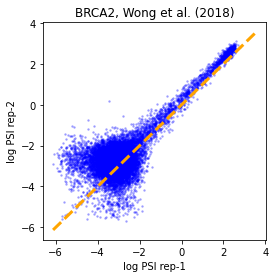

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(BRCA_df['y1'],BRCA_df['y2'],s=2.5,color='blue',alpha=0.25)
ax.set_xlabel('log PSI rep-1')
ax.set_ylabel('log PSI rep-2')
ax.set_title('BRCA2, Wong et al. (2018)')
lims = ax.get_ylim()
ax.plot(lims,lims,linestyle='--',color='orange',lw=3)

In [21]:
# Separate test from data_df
ix_test = BRCA_df['set']=='test'
test_df = BRCA_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

test N: 2,104


## Set data 

In [24]:
# Set training data
model.set_data(x=BRCA_df['x'],
               y_list=BRCA_df[['y1','y2']],
               validation_flags=(BRCA_df['set']=='validation'),
               shuffle=False)

MavennError: Length of y_list must be equal to mp_list 

In [ ]:
model.y_norm

Note that linear initialization currently won't work with more than one y target

In [ ]:
# # Fit model to data
# history = model.fit(learning_rate=.0005,
#                     epochs=1,
#                     batch_size=50,
#                     early_stopping=True,
#                     linear_initialization=False)


# Fit model to data
history = model.fit(learning_rate=.0001,
                    epochs=1000,
                    batch_size=100,
                    early_stopping=True,
                    early_stopping_patience=30,
                    linear_initialization=False)

In [23]:
plt.figure(figsize=(4,4))
plt.plot(model.history['loss'], color='blue')
plt.plot(model.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])

AttributeError: 'Model' object has no attribute 'history'

<Figure size 288x288 with 0 Axes>

In [23]:
# phi = gpmap.x_to_phi(x_test)
# mp_GE.phi_to_yhat(phi)
x_test = test_df['x']
y1_test = test_df['y1']
y2_test = test_df['y2']

In [24]:
# phi = gpmap.x_to_phi(x_test)

# yhat1 = mp_GE_1.phi_to_yhat(phi)
# yhat2 = mp_GE_2.phi_to_yhat(phi)

In [25]:

# fig, axs = plt.subplots(2,2,figsize=(8,8))

# ax = axs[0,0]

# ax.scatter(phi,y1_test,s=3,alpha=0.3,c='blue')
# ax.scatter(phi,yhat1,s=5,alpha=0.9,c='orange',label=f'$g_{1}(\phi)$')

# ax.set_title('Rep-1')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('phi')
# ax.legend()

# ax = axs[0,1]

# ax.scatter(yhat1,y1_test,s=5,alpha=0.3,c='blue')
# ax.set_title('Rep-1')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('yhat-1')


# ax = axs[1,0]
# ax.scatter(phi,y2_test,s=3,alpha=0.3,c='b')
# ax.scatter(phi,yhat2,s=3,alpha=0.9,c='orange',label=f'$g_{2}(\phi)$')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('phi')
# ax.set_title('Rep-2')

# ax = axs[1,1]

# ax.scatter(yhat2,y2_test,s=5,alpha=0.3,c='blue')
# ax.set_title('Rep-2')
# ax.set_ylabel('log PSI (test)')
# ax.set_xlabel('yhat-2')


# fig.tight_layout()

In [26]:
# plt.scatter(yhat1,yhat2)

In [27]:
from mavenn.src.utils import x_to_stats
stats = x_to_stats(x=x_test, alphabet=model.alphabet)
x_ohe_test = stats.pop('x_ohe')

In [43]:
import tensorflow as tf
import tensorflow.keras.backend as K


y_test = np.hstack([y1_test.values.reshape(-1,1),y2_test.values.reshape(-1,1)])

y_hat_functions = []
yhats = []

for _ in range(2):
    y_hat_functions.append(K.function([model.model.layers[0].input], [model.model.layers[2*_+3].output]))
    yhats.append(np.squeeze(y_hat_functions[_](np.hstack([x_ohe_test,y_test]))))

In [40]:
phi_function = K.function([model.model.layers[0].input], [model.model.layers[2].output])
phi = np.squeeze(phi_function(np.hstack([x_ohe_test,y_test])))

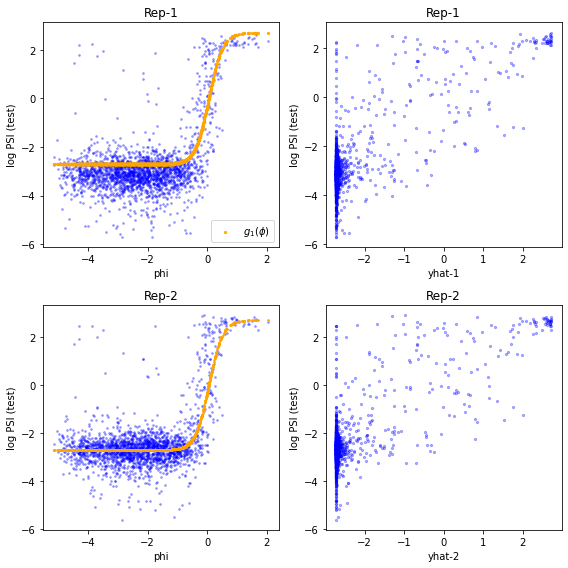

In [53]:

fig, axs = plt.subplots(2,2,figsize=(8,8))

ax = axs[0,0]

ax.scatter(phi,y1_test,s=3,alpha=0.3,c='blue')
ax.scatter(phi,yhats[0],s=5,alpha=0.9,c='orange',label=f'$g_{1}(\phi)$')

ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.legend()

ax = axs[0,1]

ax.scatter(yhats[0],y1_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-1')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-1')


ax = axs[1,0]
ax.scatter(phi,y2_test,s=3,alpha=0.3,c='b')
ax.scatter(phi,yhats[1],s=3,alpha=0.9,c='orange',label=f'$g_{2}(\phi)$')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('phi')
ax.set_title('Rep-2')

ax = axs[1,1]

ax.scatter(yhats[1],y2_test,s=5,alpha=0.3,c='blue')
ax.set_title('Rep-2')
ax.set_ylabel('log PSI (test)')
ax.set_xlabel('yhat-2')


fig.tight_layout()

In [48]:
y_hat_functions_1 = K.function([model.model.layers[0].input], [model.model.layers[3].output])
y_hat_functions_2 = K.function([model.model.layers[0].input], [model.model.layers[5].output])

yhats_1 = np.squeeze(y_hat_functions_1(np.hstack([x_ohe_test,y_test])))
yhats_2 = np.squeeze(y_hat_functions_2(np.hstack([x_ohe_test,y_test])))

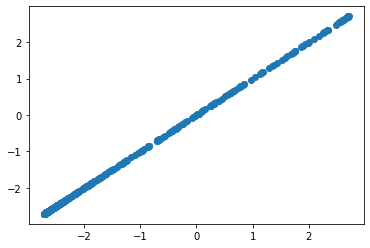

In [51]:
plt.scatter(yhats_1,yhats_2)

array([-2.7075403, -2.7128334, -2.7128232, ..., -2.7102644, -2.7099912,
       -2.713003 ], dtype=float32)